# Разработка стратегии взаимодействия с клиентами фитнес-клуба на основе аналитических данных

**Цель исследования:**
- Определить причины оттока клиентов фитнес-клуба

**Описание данных (месяц до оттока и факт оттока на определённый месяц):**

*Данные клиента за предыдущий до проверки факта оттока месяц:*
* gender — пол;
* Near_Location — проживание или работа в районе, где находится фитнес-центр;
* Partner — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* Phone — наличие контактного телефона;
* Age — возраст;
* Lifetime — время с момента первого обращения в фитнес-центр (в месяцах).


*Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:*
* Contract_period — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
* Month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах);
* Group_visits — факт посещения групповых занятий;
* Avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента;
* Avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц;
* Avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

## 1. Обзор данных

**Импорт библиотек**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

/Users/yusuf/opt/anaconda3/envs/praktikum_env_macos2/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [14]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.precision',2)
sns.set(rc={'figure.figsize':(16, 9)})

In [3]:
data = pd.read_csv('/Users/yusuf/Desktop/Programming/Projects/Data/gym_churn.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [6]:
data.columns = data.columns.str.lower()

In [8]:
data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.23,5.0,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.0,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.0,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.0,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.0,3,1.11,1.12,0


In [9]:
print('Количество дубликатов в данных:', data.duplicated().sum())

Количество дубликатов в данных: 0


* Пропуски отсутствуют;
* Заголовки приведены к нижнему регистру.

## 2. Проведение исследовательского анализа данных (EDA)

In [10]:
data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.00,4000.00,4000.00,4000.00,4000.0,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00
mean,0.51,0.85,0.49,0.31,0.9,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.3,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.0,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.0,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.0,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.0,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.0,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


На основе полученных данных можно сказать, что:
* Разделение между полами практически идеальное (51/49);
* Большинство клиентов работают поблизости (85%);
* Половина клиентов являются сотрудниками компаний-партнеров (49%);
* Треть клиентов получены в рамках акции "приведи друга" (31%);
* Большинство клиентов оставили свой номер телефона (90%);
* Длительность абонимента в среднем 4.68 месяца, при этом медианное значение 1 месяц - большая часть клиентов не продливают занятия;
* Почти половина клиентов посещают групповые занятия (41%);
* Средний возраст клиентов - 29 лет;
* Средний дополнительные заработок с клиента - 147 денежных единиц;
* Среднее значение оставшихся до окончания абонимента месяцев - 4.68, при этом медиана также 1 месяц;
* Клиенты в среднем пользуются услугами клуба 4 месяца, по медиане 3 месяца;
* Клиенты посещают фитнес-клуб 2 раза в неделю;
* Фитнес-клуб в среднем теряет четверть своих клиентов (27%).

In [11]:
data.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.51,0.87,0.53,0.35,0.9,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
1,0.51,0.77,0.36,0.18,0.9,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04


Покинувшие фитнес-клуб в этом месяце:
* Находились дальше от клуба;
* У них меньше друзей ходит в этот же клуб;
* Меньше ходили на групповые занятия;
* Были немного младше (27 лет);
* В целом меньше посещали фитнес-клуб.

### 2.1 Распределение признаков на тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

In [15]:
churn = data.loc[data['churn'] == 1]
stay = data.loc[data['churn'] == 0]

In [16]:
binary_features = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']
quantitive_features = ['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']

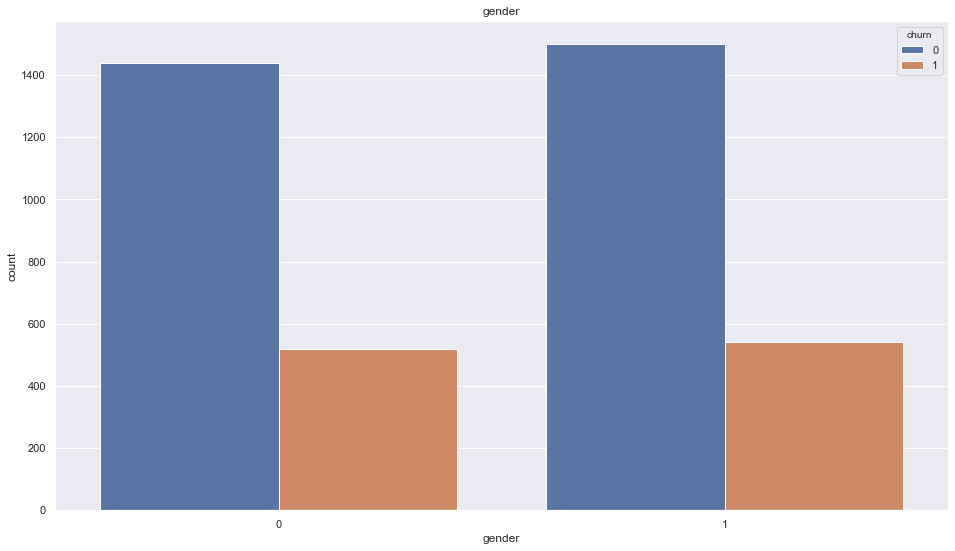

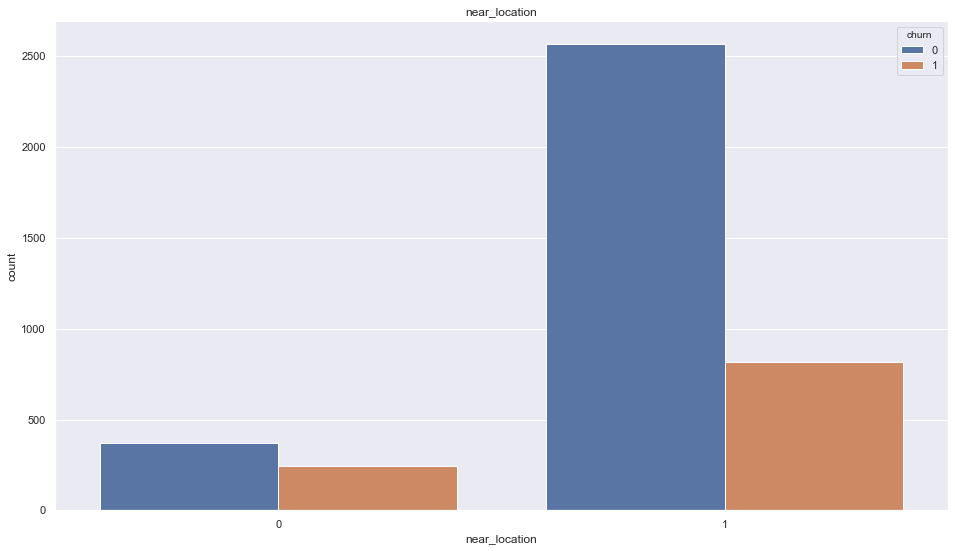

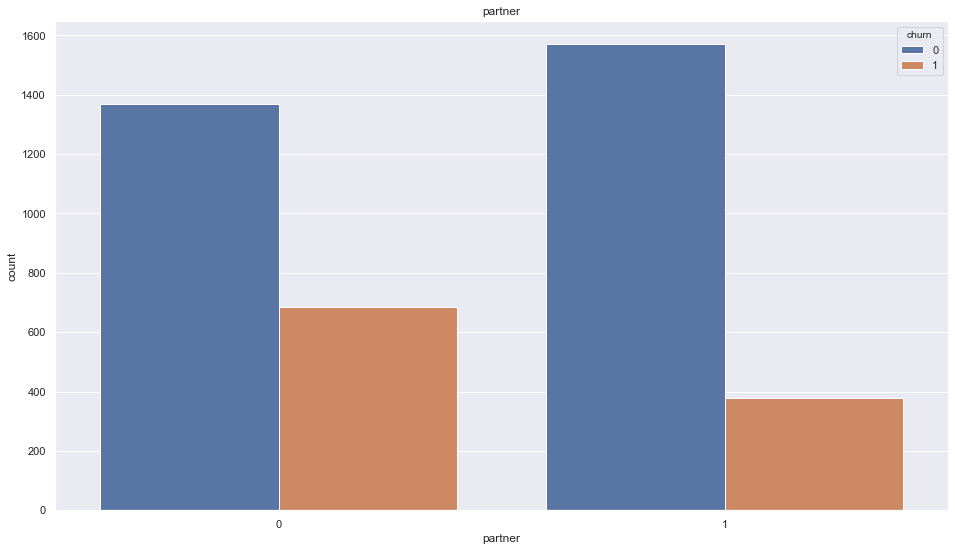

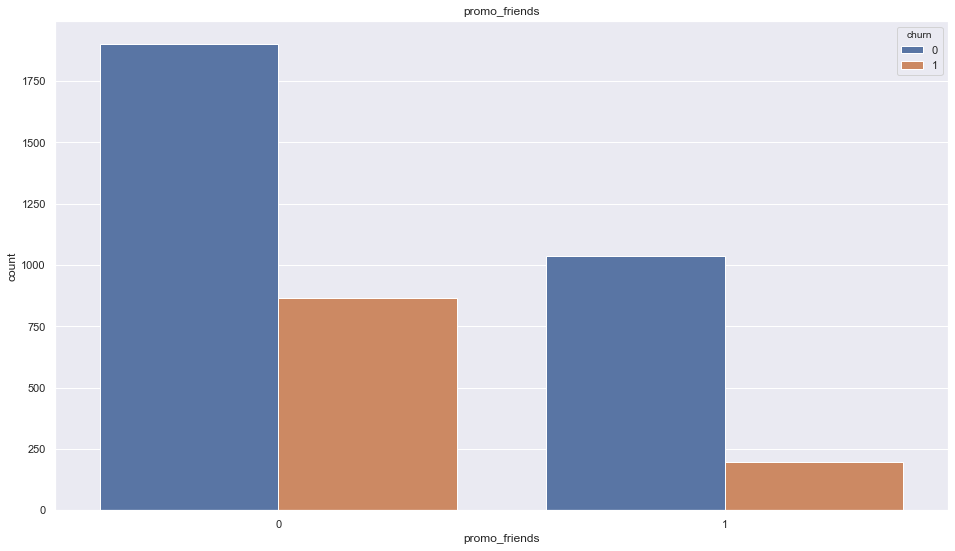

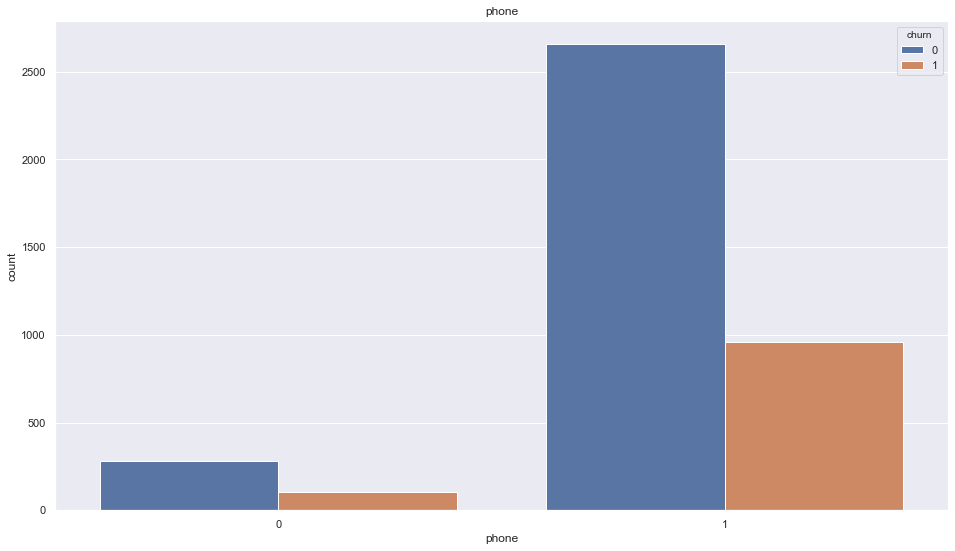

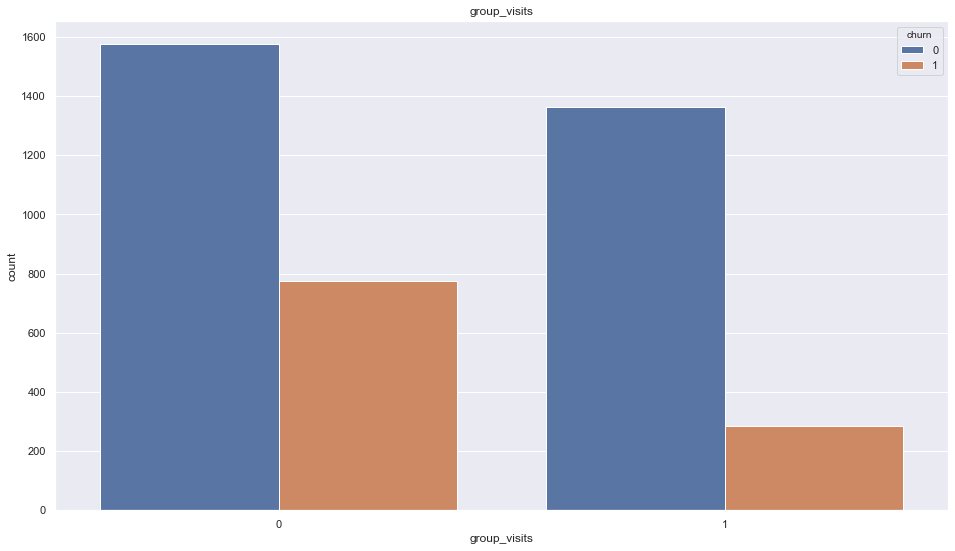

In [18]:
for column in binary_features:
    plt.figure()
    sns.countplot(x = data[column], hue='churn', data=data)
    plt.title(column)
    plt.show()

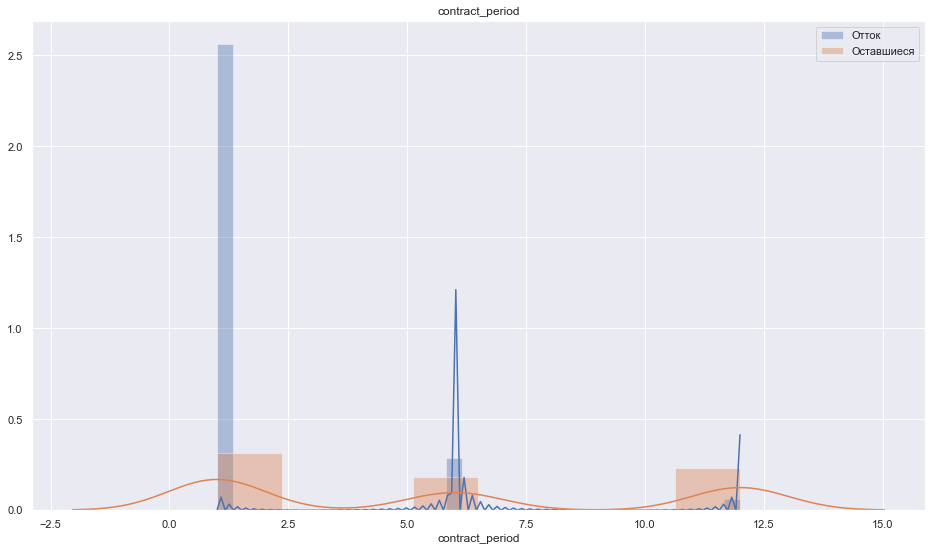

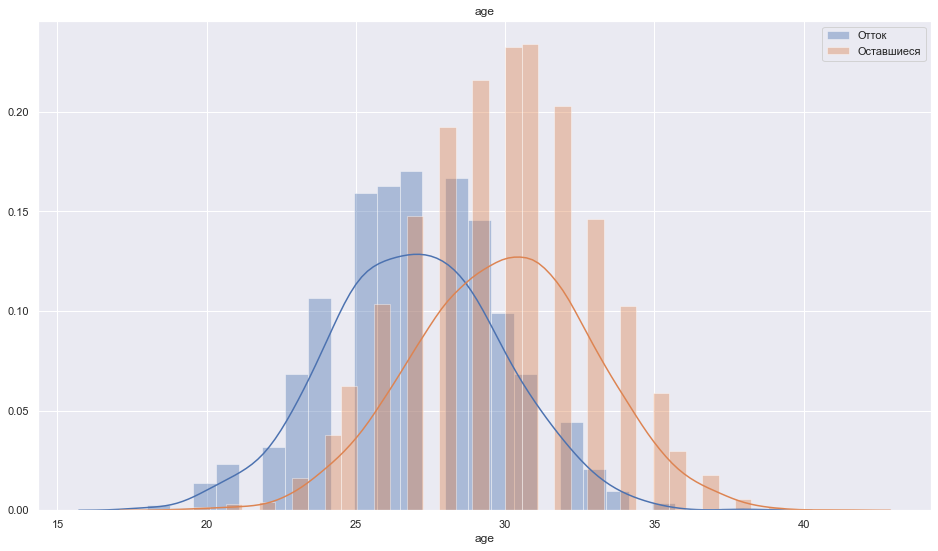

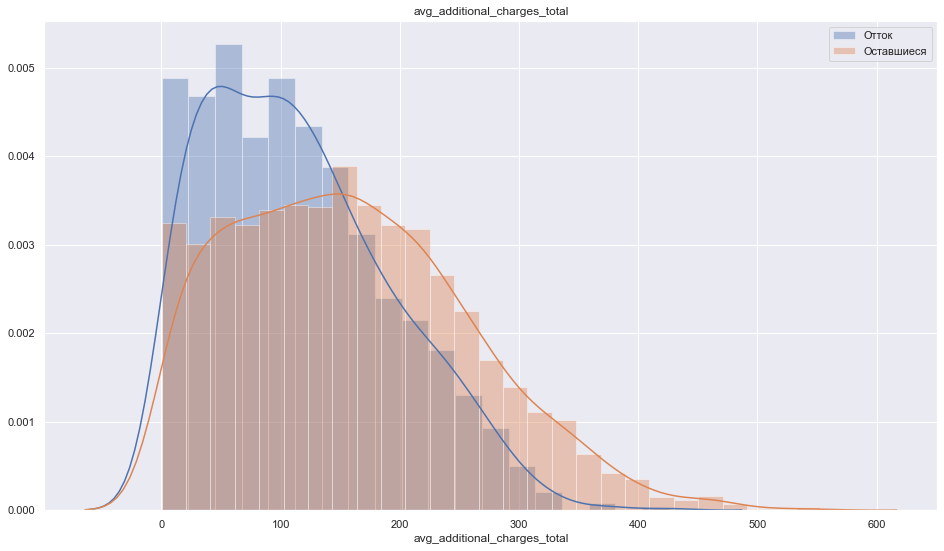

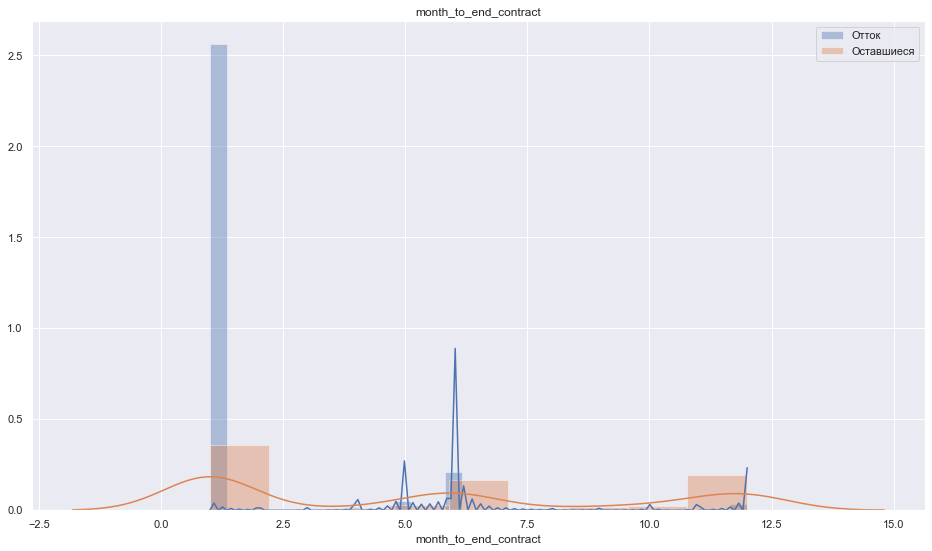

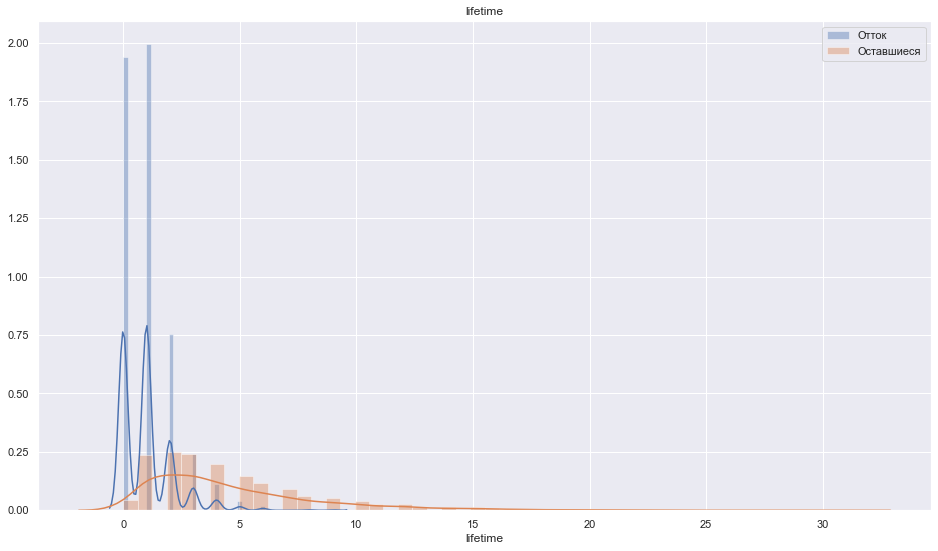

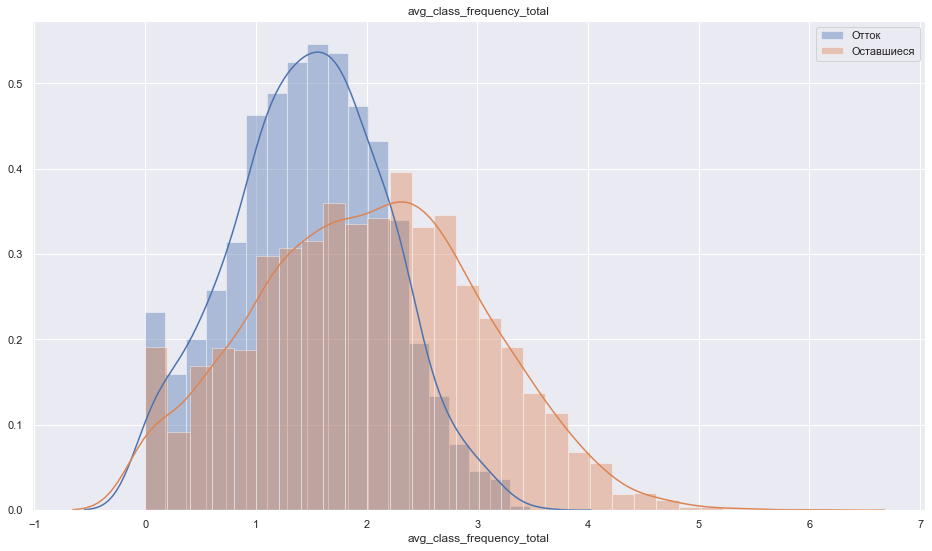

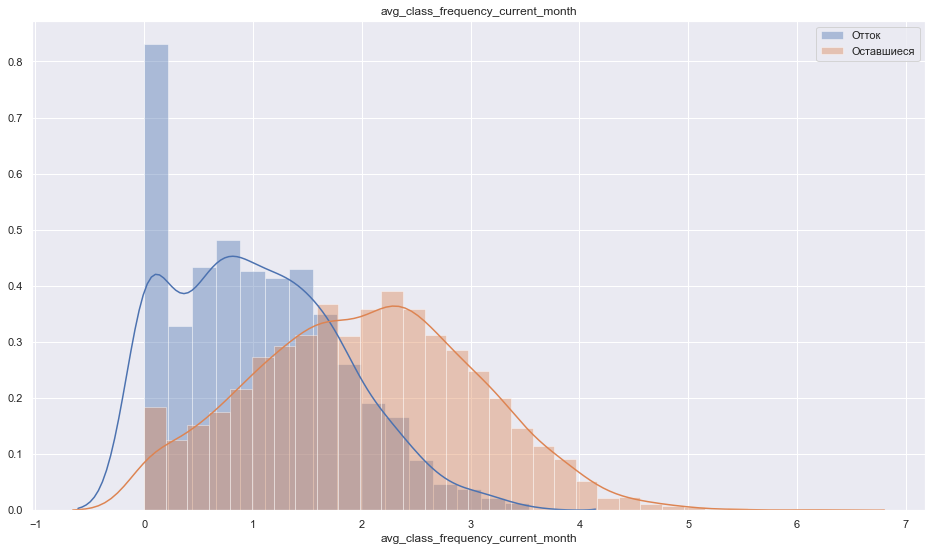

In [19]:
distplot_columns = quantitive_features
for column in distplot_columns: 
    plt.figure() 
    plt.title(column)
    sns.distplot(churn[column])
    sns.distplot(stay[column])
    plt.legend(['Отток', 'Оставшиеся'])
    plt.show()

Графики полностью подтверждают предыдущие выводы

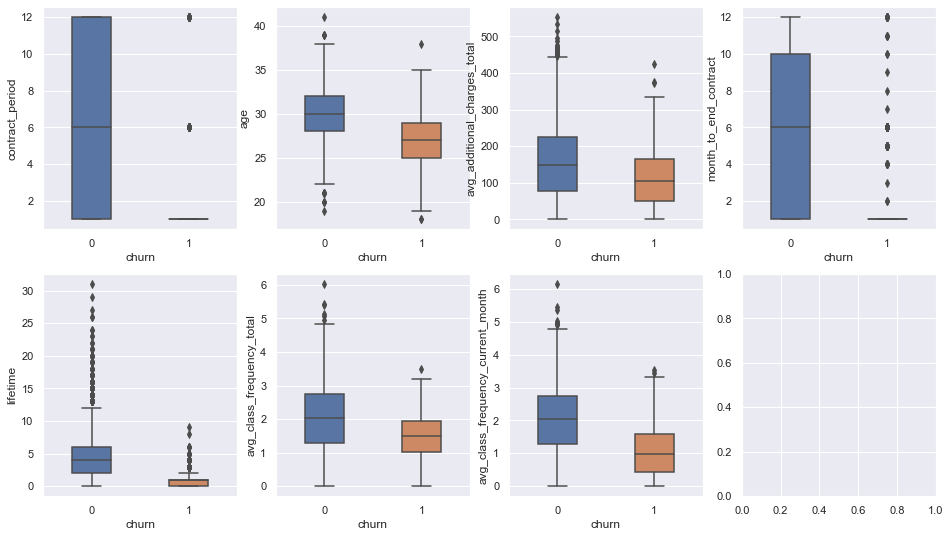

In [20]:
fig, axes = plt.subplots(2,4)
ax = sns.boxplot(data = data, x = 'churn', y=quantitive_features[0], width=0.4, ax=axes[0,0])
ax = sns.boxplot(data = data, x = 'churn', y=quantitive_features[1], width=0.4, ax=axes[0,1])
ax = sns.boxplot(data = data, x = 'churn', y=quantitive_features[2], width=0.4, ax=axes[0,2])
ax = sns.boxplot(data = data, x = 'churn', y=quantitive_features[3], width=0.4, ax=axes[0,3])
ax = sns.boxplot(data = data, x = 'churn', y=quantitive_features[4], width=0.4, ax=axes[1,0])
ax = sns.boxplot(data = data, x = 'churn', y=quantitive_features[5], width=0.4, ax=axes[1,1])
ax = sns.boxplot(data = data, x = 'churn', y=quantitive_features[6], width=0.4, ax=axes[1,2])

Количественные признаки указывают на следующие выводы:
* Чем дольше контракт, тем меньше вероятность ухода;
* Чем дольше клиент взаимодействует с фитнес-клубом, тем меньше вероятность ухода.

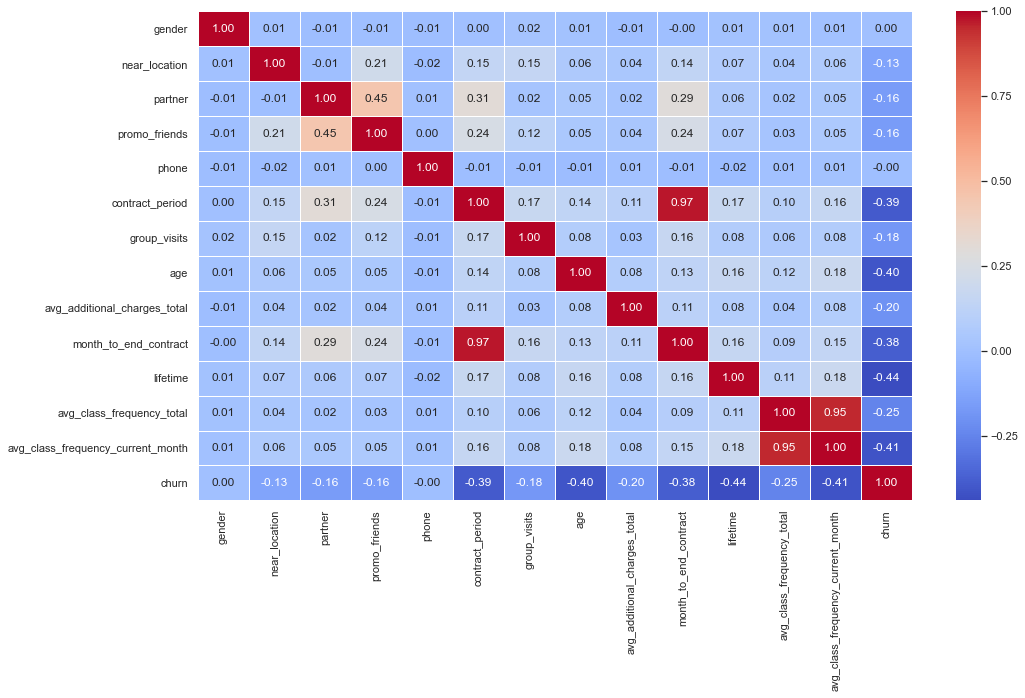

In [21]:
cm = data.corr()
plt.figure()
sns.heatmap(cm, annot = True, fmt = '0.2f', linewidths=.5, cmap="coolwarm")
plt.show()

Удалим признаки наибольшей корреляции

In [22]:
data = data.drop(['avg_class_frequency_current_month', 'month_to_end_contract'], axis=1)

Наибольшая корреляция наблюдается между:
* Длительностью абонемента и сроком до его окончания (97%);
* Посещаемостью за последний месяц и за всё время (95%);
* Фактом записи через акцию "приведи друга" и участником компании партнера (45%).

## 3. Постройка модели прогнозирования оттока клиентов

Целевой признак - факт оттока клиента в следующем месяце

In [23]:
X = data.drop('churn', axis=1)
y = data['churn']

In [24]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,  stratify = y )

In [25]:
log_reg_model = LogisticRegression(random_state=0, max_iter=5000, solver='lbfgs')
log_reg_model.fit(x_train,y_train)
log_reg_predictions = log_reg_model.predict(x_test)

dec_tree_model = DecisionTreeClassifier(random_state=0)
dec_tree_model.fit(x_train,y_train)
dec_tree_predictions = dec_tree_model.predict(x_test)

/Users/yusuf/opt/anaconda3/envs/praktikum_env_macos2/lib/python3.7/site-packages/sklearn/utils/fixes.py:223: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):


In [26]:
print('Метрики LogisticRegression:')
print('Accuracy - {:.2f}'.format(accuracy_score(y_test, log_reg_predictions)))
print('Precision - {:.2f}'.format(precision_score(y_test, log_reg_predictions)))
print('Recall - {:.2f}'.format(recall_score(y_test, log_reg_predictions)))

print('Метрики DecisionTreeClassifier:')
print('Accuracy - {:.2f}'.format(accuracy_score(y_test, dec_tree_predictions)))
print('Precision - {:.2f}'.format(precision_score(y_test, dec_tree_predictions)))
print('Recall - {:.2f}'.format(recall_score(y_test, dec_tree_predictions)))

Метрики LogisticRegression:
Accuracy - 0.91
Precision - 0.82
Recall - 0.83
Метрики DecisionTreeClassifier:
Accuracy - 0.86
Precision - 0.73
Recall - 0.74


Логистическая регрессия более точна по всем параметрам

## 4. Кластеризация пользователей

In [27]:
scaler = StandardScaler()
scaler.fit(X)
X_st = scaler.transform(X)

In [28]:
linked = linkage(X_st, method = 'ward') 

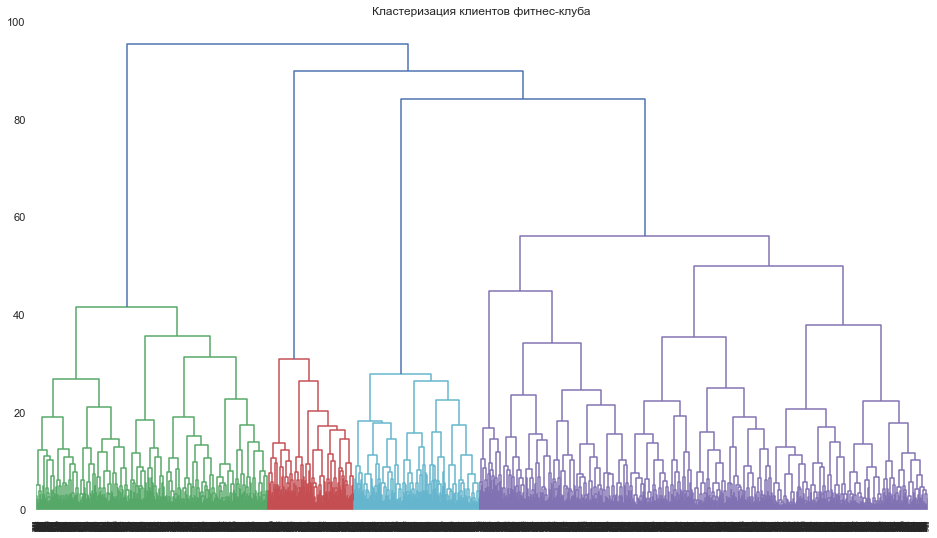

In [29]:
plt.figure()  
dendrogram(linked, orientation = 'top')
plt.title('Кластеризация клиентов фитнес-клуба')
plt.show()

С помощью визуальзации алгоритма получаем 4 кластера (по цветам) и 5 по условию - вероятно правый кластер разбивается на 2

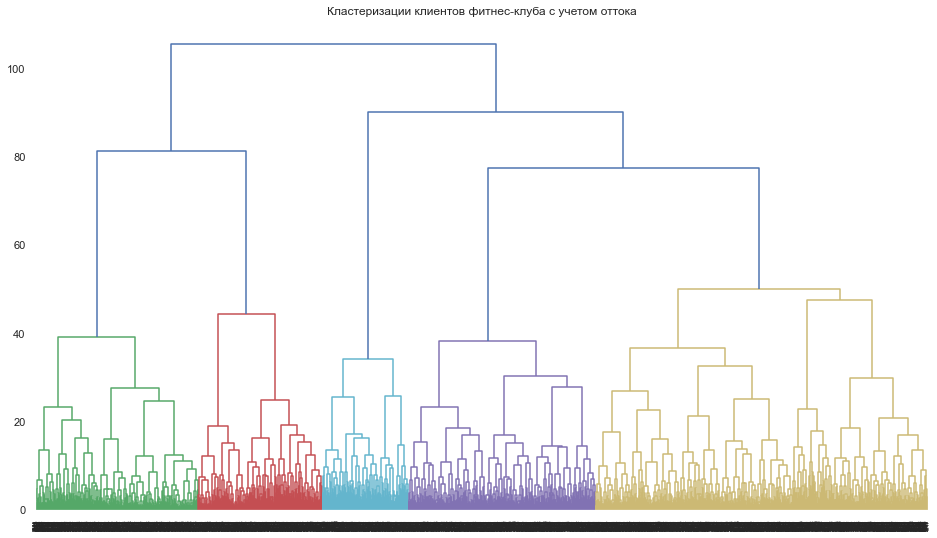

In [30]:
scaler = StandardScaler() 
data_sc = scaler.fit_transform(data) 
linked = linkage(data_sc, method = 'ward')
plt.figure()  
dendrogram(linked, orientation='top')
plt.title('Кластеризации клиентов фитнес-клуба с учетом оттока')
plt.show()

In [31]:
km = KMeans(n_clusters = 5, random_state = 0)
k_means_clusters = km.fit_predict(X_st)
data['clusters'] = k_means_clusters

### 4.1 Изучение среднего значения признаков кластеров

In [32]:
data.groupby('clusters').mean().sort_values(by='churn')

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
clusters,,,,,,,,,,,,
1,0.49,1.00,0.96,0.89,1.0,7.66,0.46,29.54,155.86,4.38,1.98,0.12
3,0.54,1.00,0.25,0.08,1.0,4.53,1.00,29.54,148.09,3.76,1.94,0.20
4,0.52,0.86,0.47,0.31,0.0,4.78,0.43,29.30,144.21,3.94,1.85,0.27
2,0.51,1.00,0.24,0.06,1.0,2.82,0.00,28.77,143.38,3.34,1.80,0.38
0,0.50,0.00,0.49,0.08,1.0,3.03,0.24,28.72,137.54,3.06,1.77,0.40


* 1 кластер (отток 12%) - близко к локации, партнер клуба, привели друзья, половина тренировок состоит из групповых 
* 2 кластер (отток 20%) - близко к локации, четверть являются партнероми клуба, не приводили друзья, все тренировки групповые 
* 3 кластер (отток 27%) - чуть дальше от локации, половина является партнерами клуба, треть привела друзья, половина тренировок состоит из групповых
* 4 кластер (отток 38%) - близко к локации, четверть являются партнероми клуба, не приводили друзья, не ходит на групповые тренировки
* 0 кластер (отток 40%) - далеко от локации, половина является партнерами клуба, не приводили друзья, четверть тренировок групповые

### 4.2 Распределение признаков для кластеров

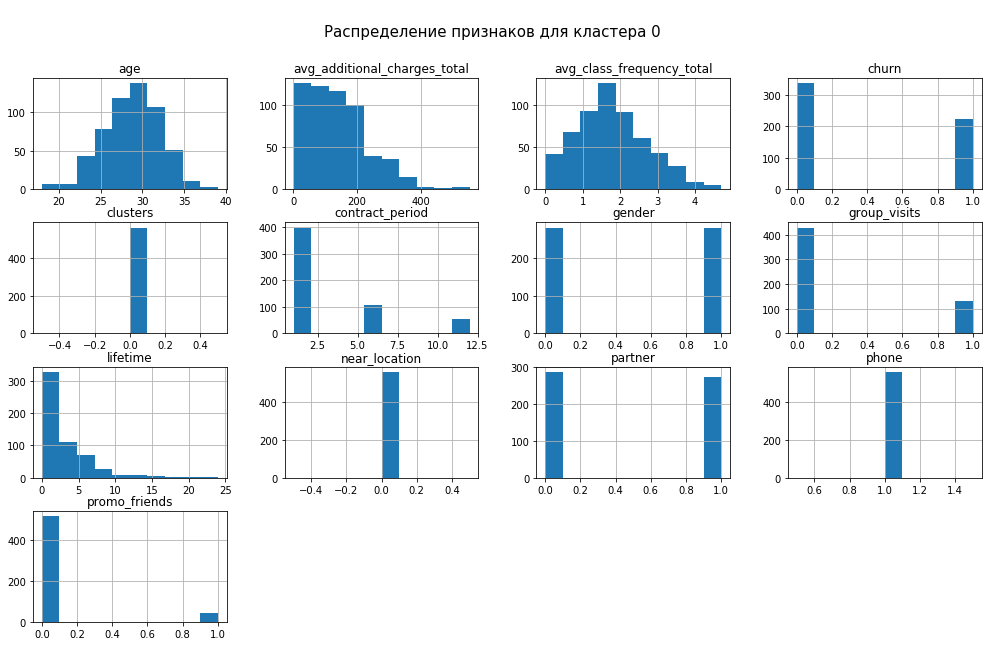

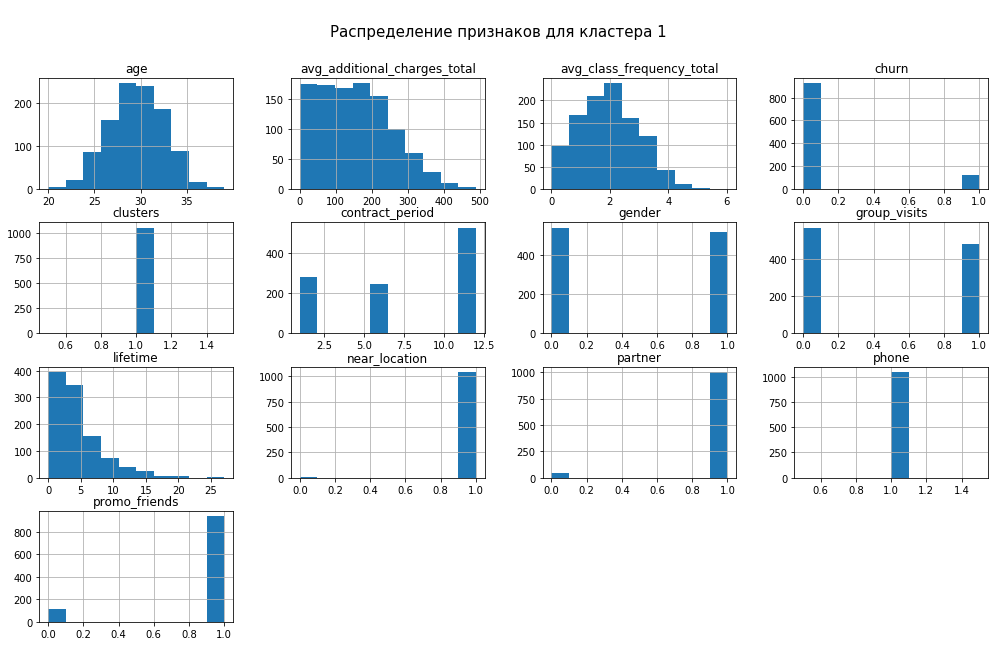

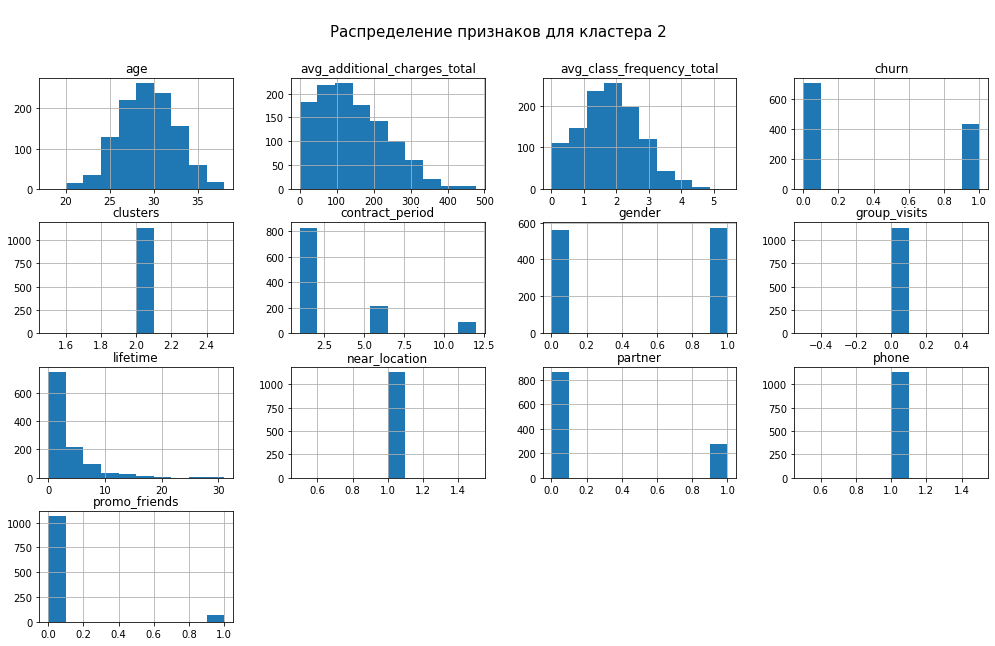

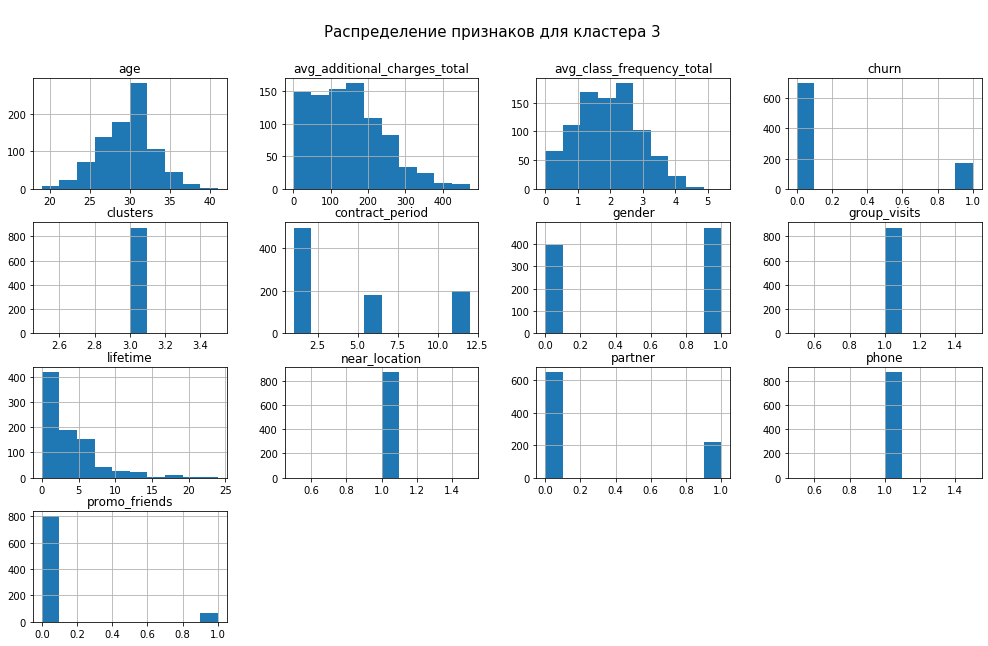

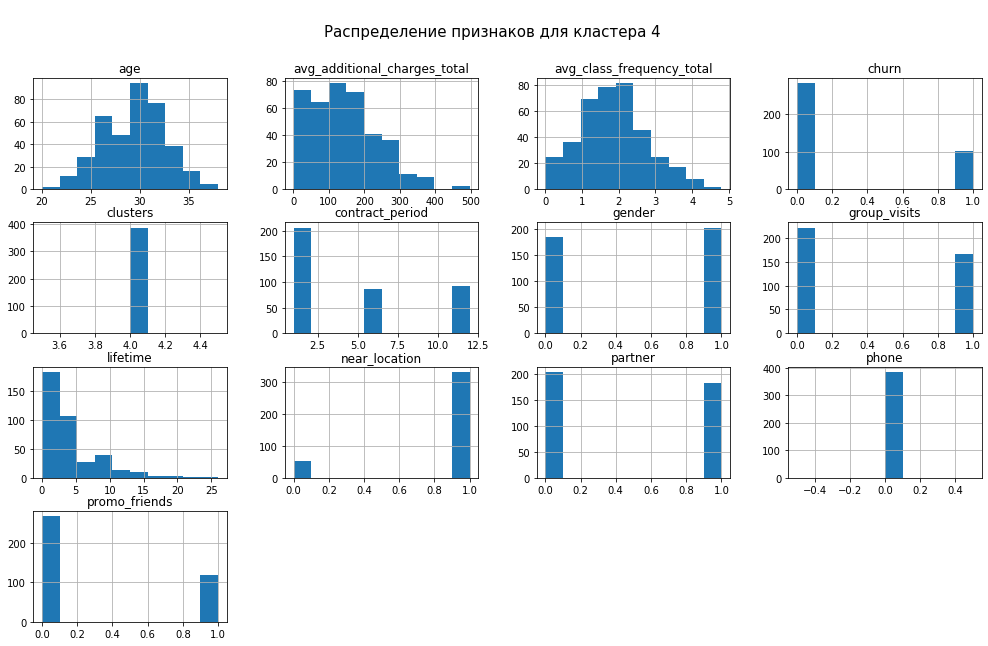

In [32]:
for value in [0, 1, 2, 3, 4]:
    data[data['clusters']==value].hist(figsize=(17,10))
    plt.suptitle('\nРаспределение признаков для кластера {}'.format(value), fontsize = 15)
    plt.show()

## 5. Формулировка выводов и базовых рекомендаций

- Возраст и пол не влияют на продолжительность контракта.

При этом, при уменьшении оставшегося количества месяцев, снижается вероятность продления, стоит:
* Проводить дополнительную работу с клиентами у которых заканчиваются абонементы. 
То есть программа "подписки" с ежемесячным продлением в данном случае не работает, нужно стараться продавать сразу от 6 месяцев (скидки, бонусы, дополнительные преференции).

При этом судя по всему групповые занятия являются крюком для клиентов. Соответственно предлагается:
* Сделать опрос клиентов сильных и слабых сторон групповых занятий и проработать их, сделав ещё лучше;
* Узнать, почему сам спортзал без групповых занятий не целпяет клиентов и проработать слабые стороны (мало определенных тренажеров, маденький душ, отсутствие кулера и тд)